# Advanced Lane Line Finding

### Overview

This file takes inputs of image/video and generate outputs with lanes colored.
Steps are listed as below:

1. Calibration
2. Undistortion
3. Gradient Threshold
4. Pipeline: Grad/Color Threshold
5. Perspective Transformation
6. Lane Detection
7. Image/Video Processing

---

## 1. Camera Calibration

In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

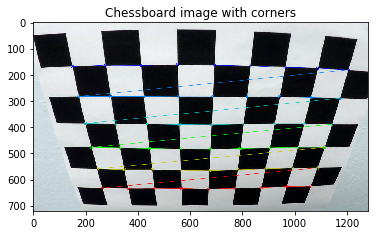

In [3]:
# For an image, find and draw chessboard corners
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

In [4]:
# #let's do the same for all images
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [5]:

# Step through the list and search for chessboard corners
for i in range(1,21):
    fname = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
print ('{} out of {} were identified with corners'.format(str(len(objpoints)),20))

17 out of 20 were identified with corners


In [6]:
#Based on corners identified, calculate calibration params
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [7]:
print (mtx)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


---
## 2. Undistortion

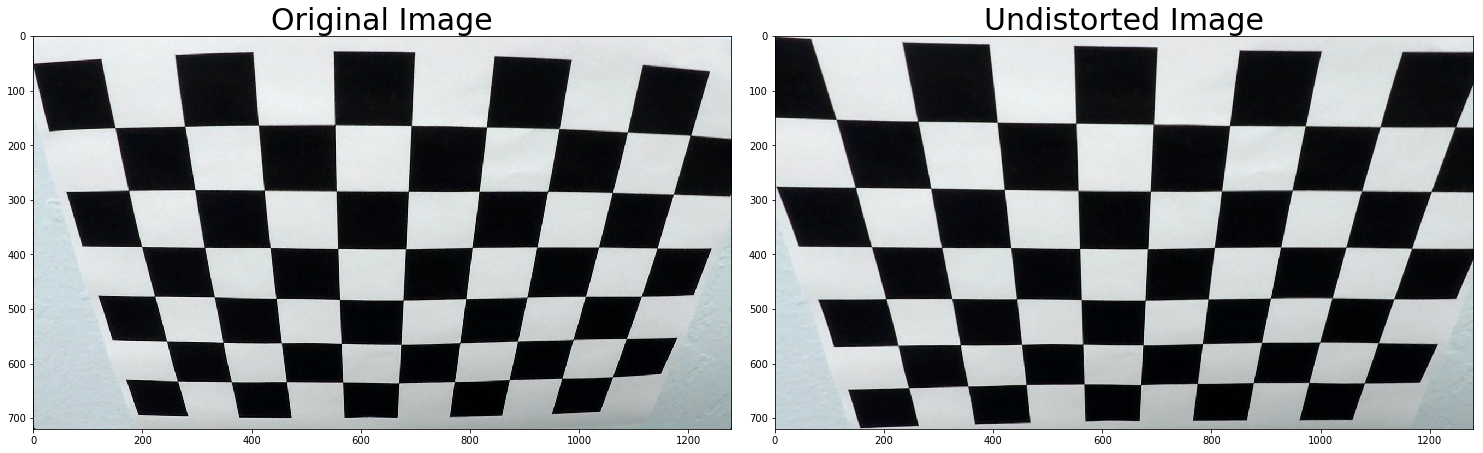

In [8]:
# For an image, correct distortion based on calibration params
fname = 'camera_cal/calibration{}.jpg'.format(2)
x=cv2.imread(fname)
y = cv2.undistort(x, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(x)
ax1.set_title('Original Image',fontsize=30)
ax2.imshow(y)
ax2.set_title('Undistorted Image',fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

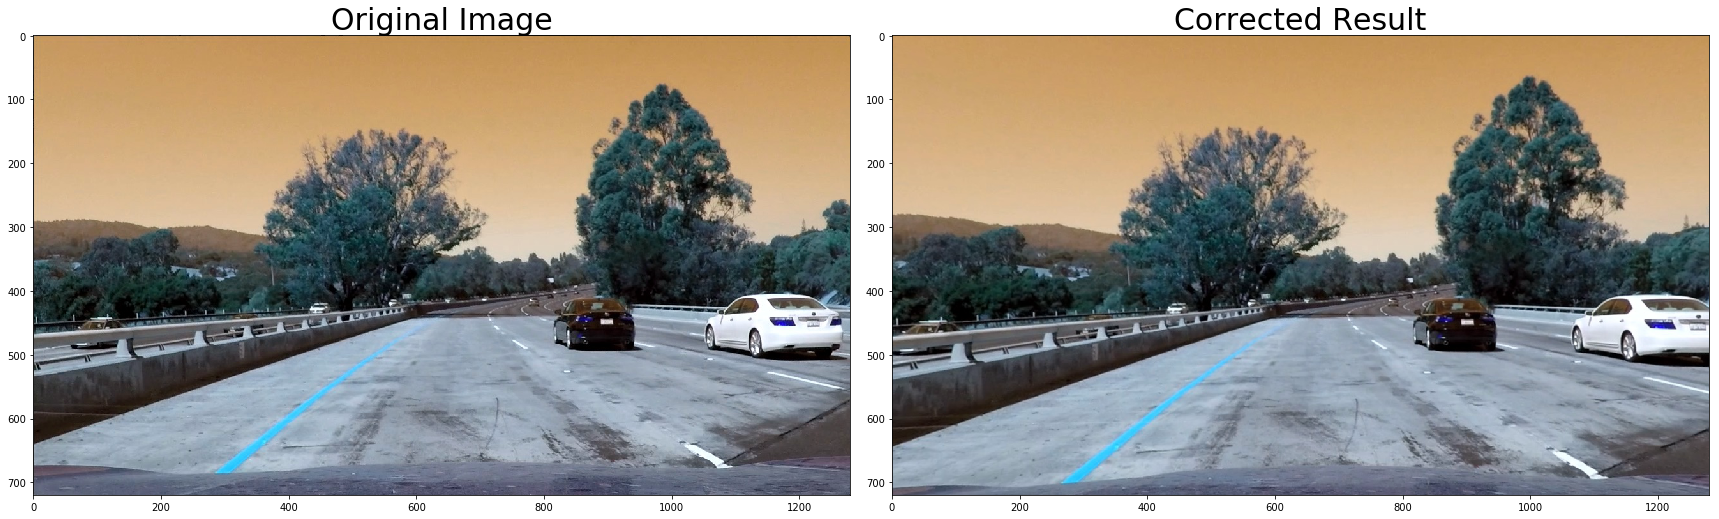

In [9]:
fname = 'test_images/test{}.jpg'.format(1)
img = cv2.imread(fname)
corrected_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(corrected_img)
ax2.set_title('Corrected Result', fontsize=30)


---
## 3. Gradient Threshold

In [10]:
# Calculate abs gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate magnitude of gradient 
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate direction of gradient 
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir =  np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

## 4. Pipeline: combine grad and color thresholds 

In [41]:
# Edit this function to create your own pipeline.
def pipeline(img): 
    # Gaussian Blurring to reduce noises
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # Conversions to hls, gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    # Define sobel kernel size
    ksize = 7    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all gradient thresholds
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Color Threshold
    s = hls[:,:,2]
    s_binary = np.zeros_like(grad_combined)
    s_binary[(s > 160) & (s < 255)] = 1
    
    # Combine gradient and color threshold
    color_binary = np.zeros_like(grad_combined)
    color_binary[(s_binary > 0) | (grad_combined > 0)] = 1
    
    return color_binary

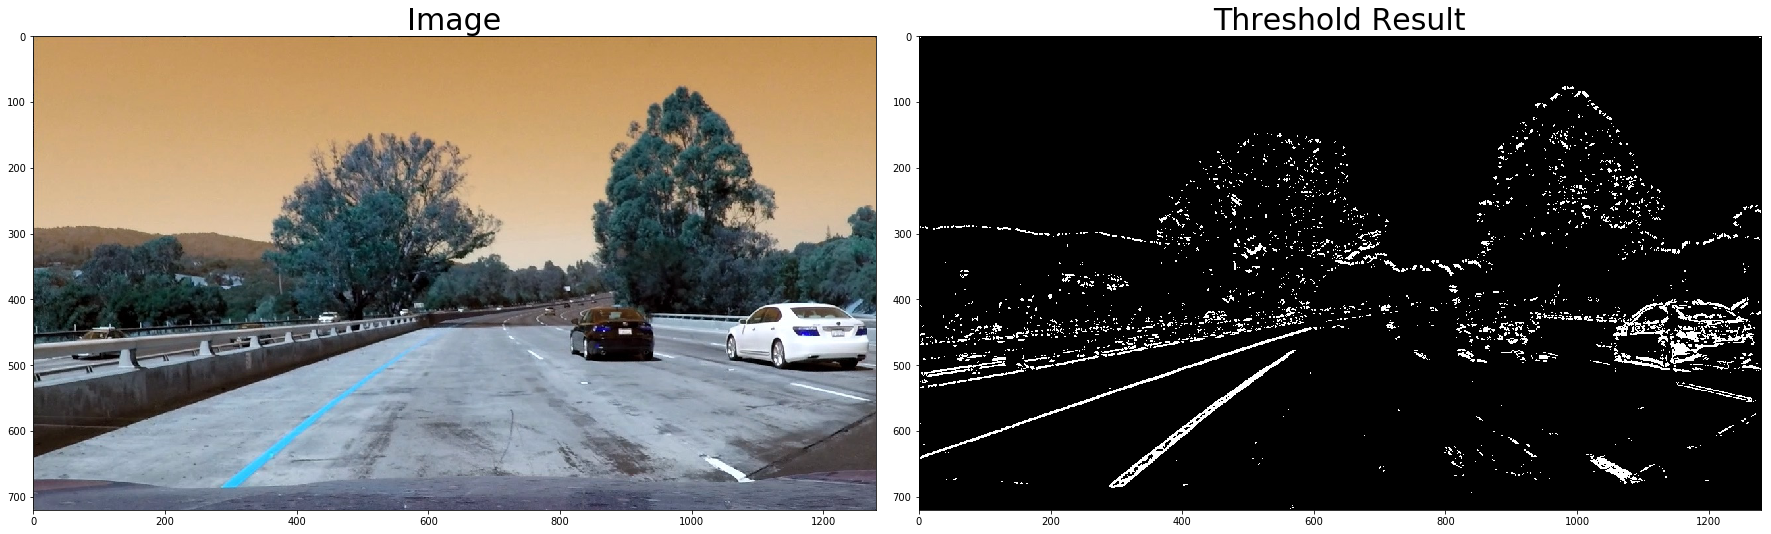

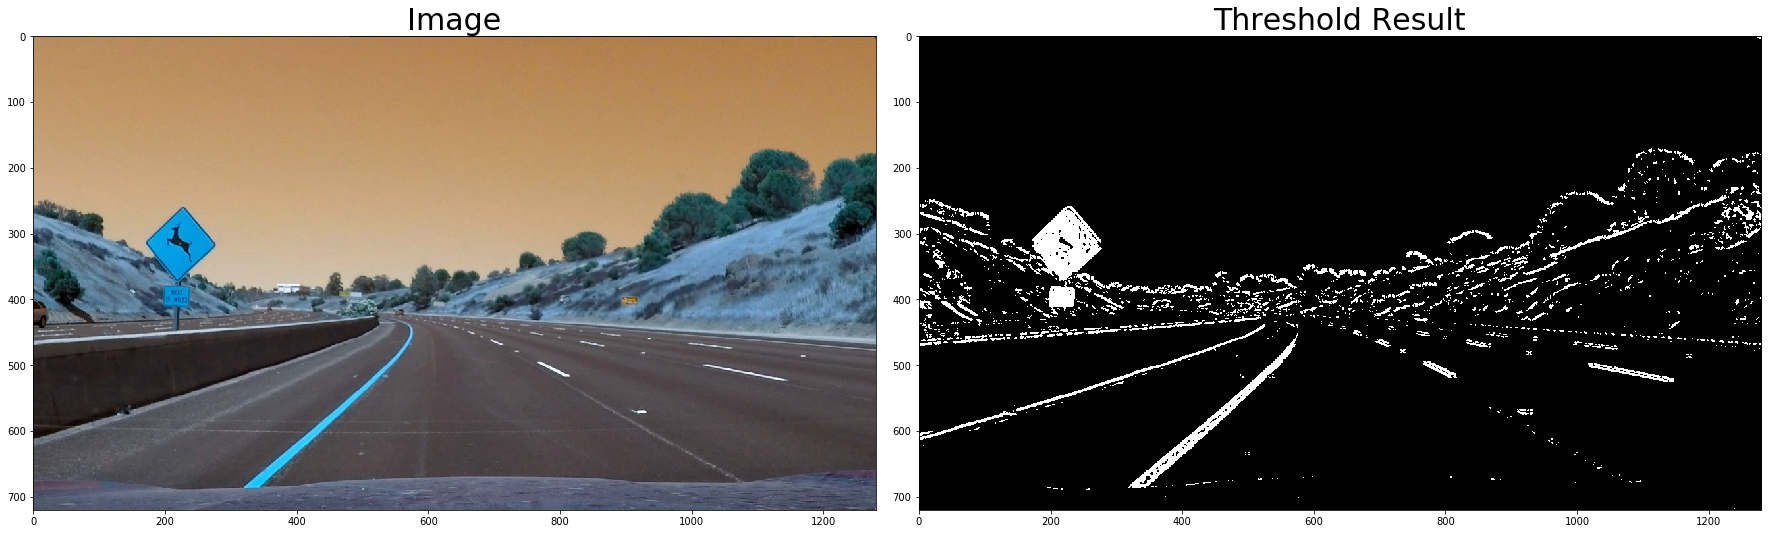

In [42]:
for i in range(1,3):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    result = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Image', fontsize=30)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Threshold Result', fontsize=30)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## 5. Perspective Transformation

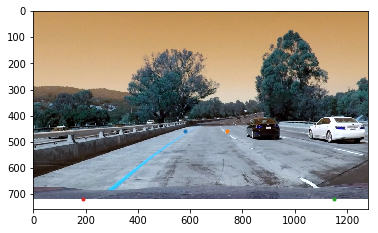

In [15]:
fname = 'test_images/test{}.jpg'.format(1)
image = cv2.imread(fname)
plt.imshow(image)

source = [[580,460],[740,460],[1150,720],[190,720]]
for i in range(len(source)):
    plt.plot(source[i][0], source[i][1],'.')

In [16]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients

def perspective_transform(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset = 200 # offset for dst points x value
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(source)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

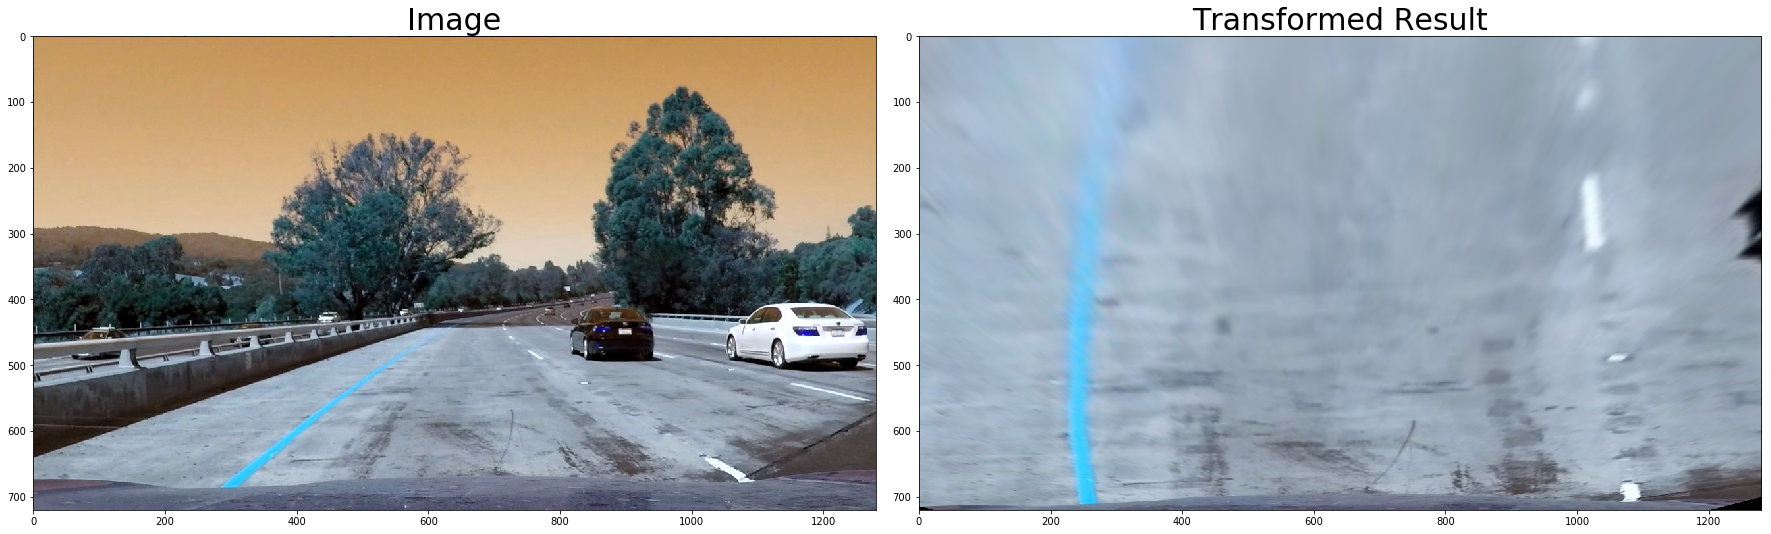

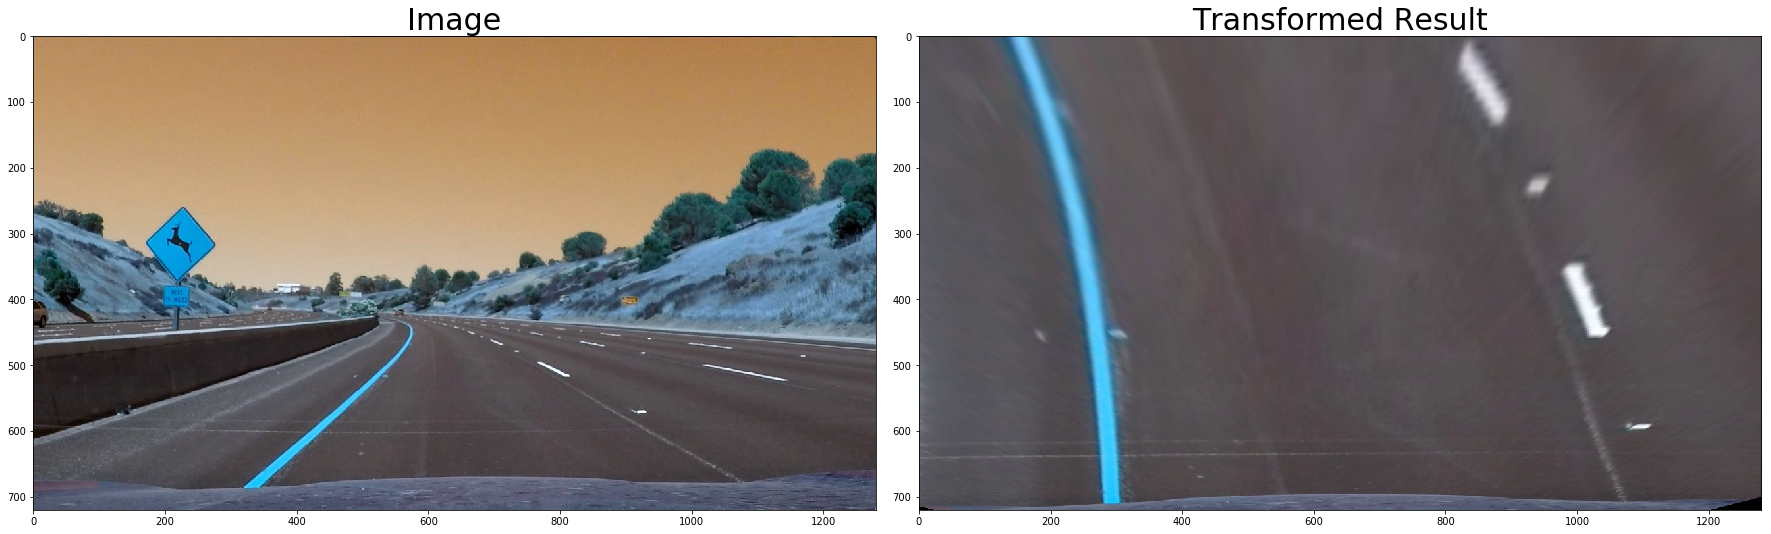

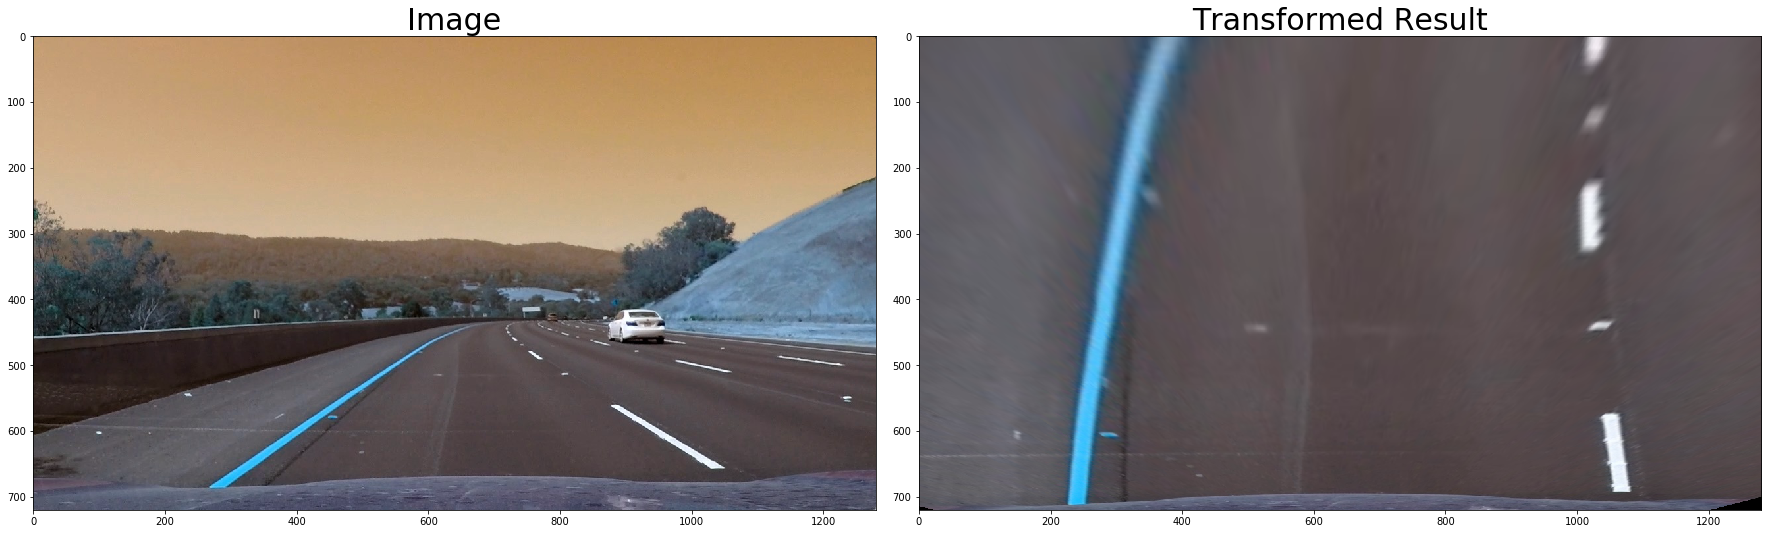

In [17]:
for i in range(1,4):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    image = pipeline(image)
    #for i in 
    top_down, perspective_M, perspective_Minv = perspective_transform(image, nx, ny, mtx, dist)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)#, cmap='gray')
    ax1.set_title('Image', fontsize=30)

    ax2.imshow(top_down)#, cmap='gray')
    ax2.set_title('Transformed Result', fontsize=30)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 6. Line Detection

In [18]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [19]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def curvature_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

In [20]:
def lane_detect(binary_warped, nwindows = 9):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if (left_lane.detected==False) and (right_lane.detected==False):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # curvature check
    left_curverad  = find_curvature(ploty, left_fitx)
    right_curverad = find_curvature(ploty, right_fitx)
    

    # curvature check  
    left_fitx  = curvature_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = curvature_check(right_lane, right_curverad, right_fitx, right_fit)
    
    # visualize
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return ploty,left_fitx, right_fitx, lefty,leftx,righty,rightx,left_curverad,right_curverad,result

In [39]:
fname = 'test_images/test{}.jpg'.format(1)
img = cv2.imread(fname)
image = pipeline(img)
# Warp the image to make lanes parallel to each other
top_down, perspective_M, perspective_Minv = perspective_transform(image, nx, ny, mtx, dist)
left_lane=Line()
right_lane=Line()
ploty,left_fitx, right_fitx, lefty,leftx,righty,rightx,left_curverad,right_curverad,out_img = lane_detect(top_down)

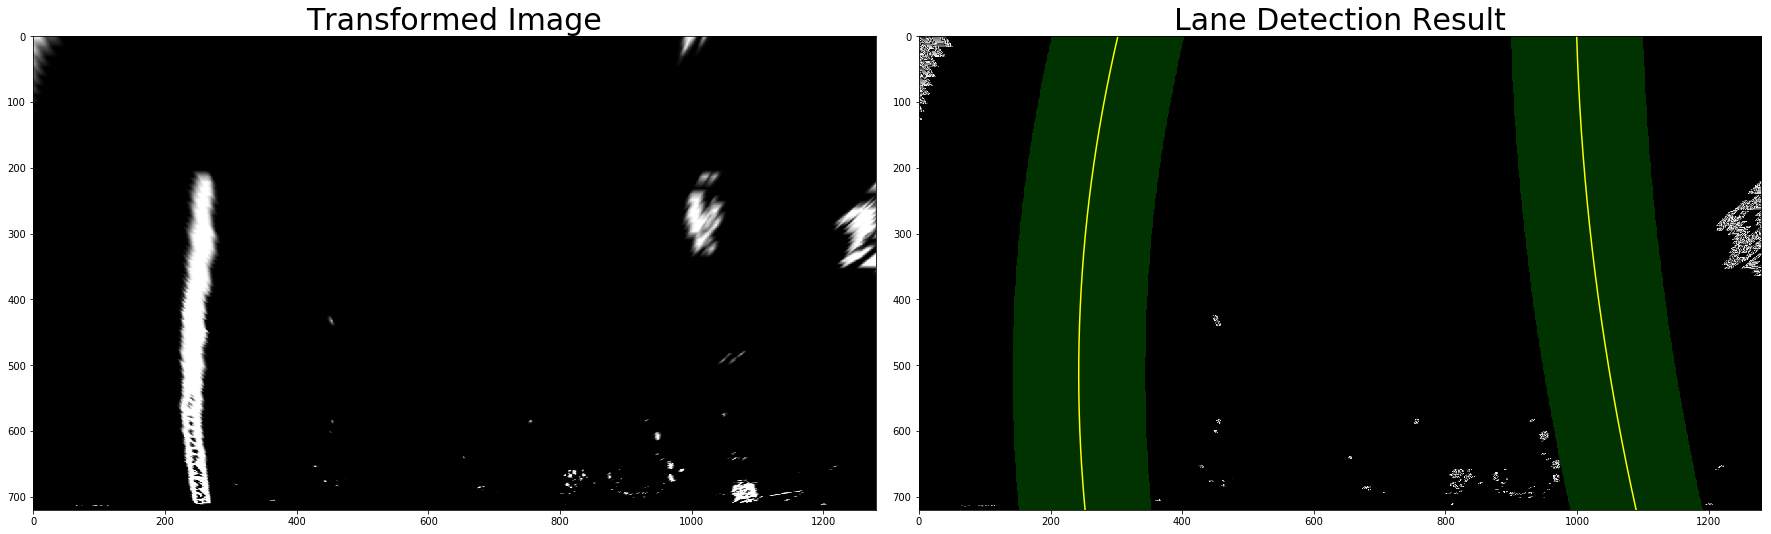

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(top_down, cmap='gray')
ax1.set_title('Transformed Image', fontsize=30)

ax2.imshow(out_img)#, cmap='gray')
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane Detection Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image and Video Processing

In [44]:
def draw_poly(image, warped, ploty, left_fitx, right_fitx, Minv,curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curverad))
    cv2.putText(result,text,(100,100), font, 1,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle: {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle: {:.2f} m right of center".format(position)
    cv2.putText(result,text,(100,150), font, 1,(255,255,255),2)
    return result

In [45]:
def find_position(pts):
    position = image.shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [46]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region

def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = pipeline(image)
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = perspective_transform(img, nx, ny, mtx, dist)
    # Find the lines fitting to left and right lanes
    ploty,left_fitx, right_fitx, lefty,leftx,righty,rightx,left_curverad,right_curverad,out_img = lane_detect(top_down)
    # Return the original image with colored region
    image_drawn= draw_poly(image, top_down, ploty,left_fitx, right_fitx,perspective_Minv,left_curverad)
    return image_drawn

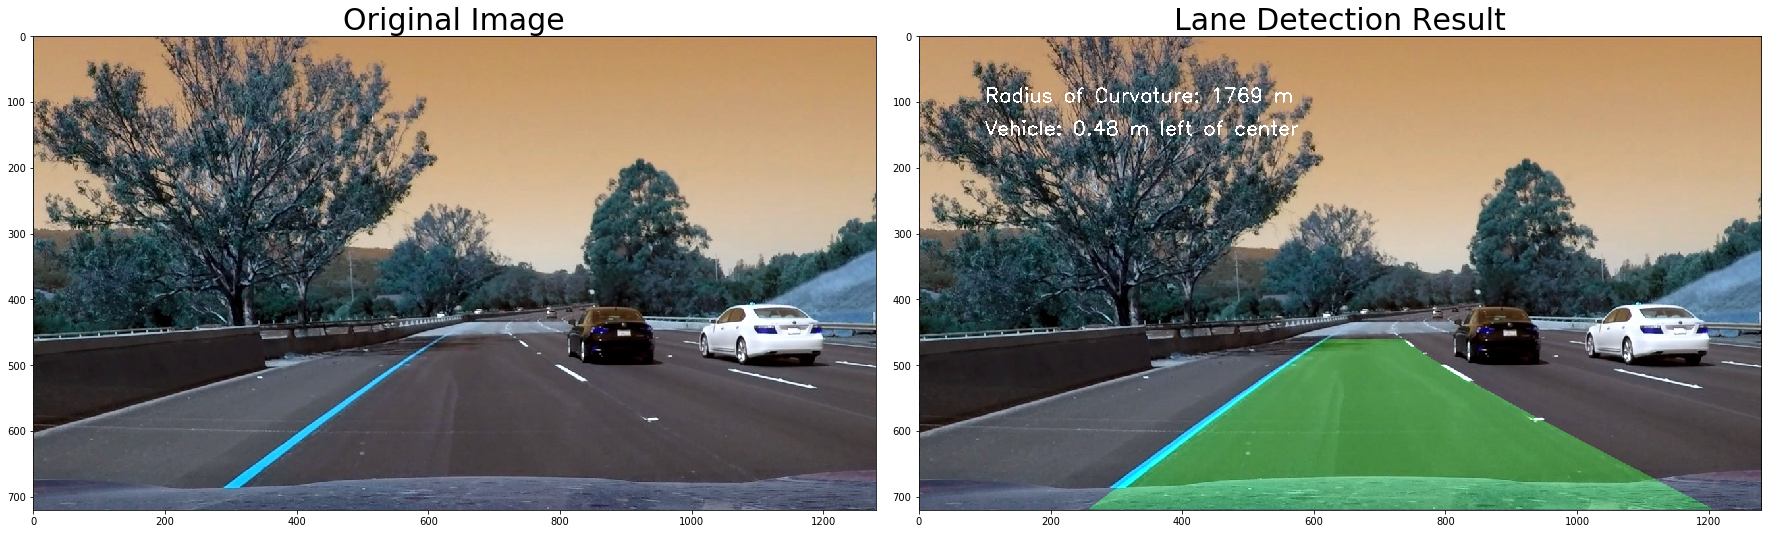

In [47]:
left_lane = Line()
right_lane = Line()
fname = 'test_images/test{}.jpg'.format(6)
img = cv2.imread(fname)
re_img = process_image(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(re_img)#, cmap='gray')
ax2.set_title('Lane Detection Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
# Video Processing

We are going to apply our model on a sample video.

The video is about 50 seconds long and the result video will shade the area between lanes and indicate the curvature and the position of the car.

In [ ]:
left_lane = Line()
right_lane = Line()
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
processed_clip.write_videofile('white.mp4', audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  3%|▎         | 33/1261 [00:09<05:18,  3.86it/s]